# Linear control system analysis (Bode etc.)

Based on lecture slides titled; Review on Linear control system analysis by prof. Kjetil Uhlen.

#### A quick introduction to assesment of stability using linear control system analysis, like assessing poles and frequency response (Bode/Nyquist)
This is the first notebook in a series providing examples and code to test concepts. Still a work in progress, if there is anything missing or you have some general feedback please contact Sjur Føyen at foyen.sjur@ntnu.no 

(uses control package; install in terminal with: pip install control)


Code implemented by; Varg Førland. Date; 29.01.2025

Last update; 03.02.2025

GitHub Copilot used for assistance in coding.

In [1]:
# INCLUDES; RUN FIRST!!! (this notebook uses the control package. Documentation found in the link below, remember to pip install control in the terminal)

import control
import matplotlib.pyplot as plt
import numpy as np

# Control package documentation
"""https://python-control.readthedocs.io/en/0.10.0/"""

# Example used for control package:
"""https://jckantor.github.io/CBE30338/05.03-Creating-Bode-Plots.html"""
# requires coefficients of the numerator and denominator polynomials
# the coefficients are given starting with the highest power of


'https://jckantor.github.io/CBE30338/05.03-Creating-Bode-Plots.html'

# Example 1 - Lecture control loop (Simple isolated power plant model)

This system will be analysed. 

Now we analyse. Interesting things to look when assessing stability:
- State Space / Poles
- Bode -> Gain and phase margins


[comment]: ![image.png](attachment:image.png)

## State Space Analysis

A **nonlinear dynamic system** with its control can generally be described by the following set of algebraic and differential equations:

$$
\dot{x} = f(x, u), \quad y = g(x, u)
$$

Where:
- $ \dot{x} $ represents the rate of change of the state variables.
- $ x $ is the state vector.
- $ u $ is the input vector.
- $ y $ is the output vector.

A **nonlinear system** can be linearized around an operating point and represented by:

$$
\Delta \dot{x} = A \Delta x + B \Delta u, \quad \Delta y = C \Delta x + D \Delta u
$$

Where:
- $ \Delta x $: Perturbation in the state variables.
- $ \Delta u $: Perturbation in the input variables.
- $ A, B, C, D $: System matrices.

---

## State Equations for a Power System Model:

### Differential Equations:
1. **Frequency Dynamics:**
   $$
   \Delta \dot{\omega}(t) = \frac{1}{2H} \left( T_m(t) - D \cdot \Delta \omega(t) - T_e(t) \right)
   $$

2. **Mechanical Torque Dynamics:**
   $$
   \Delta \dot{T}_m = \frac{1}{T_t} \left( -\Delta T_m + \Delta c \right)
   $$

3. **Governor Dynamics:**
   $$
   \Delta c = \frac{1}{T_g} \left( -\Delta c + \frac{1}{R} \left( \Delta \omega_{\text{ref}} - \Delta \omega \right) \right)
   $$

---

### State Variables and Inputs:
The state variables and inputs can be defined as:

- State vector:
  $$
  \Delta x = 
  \begin{bmatrix}
  \Delta \omega \\
  \Delta T_m \\
  \Delta c
  \end{bmatrix}
  $$

- Input vector:
  $$
  \Delta u = 
  \begin{bmatrix}
  \Delta T_e \\
  \Delta \omega_{\text{ref}}
  \end{bmatrix}
  $$


#### Time domain
$$
\Delta \dot{\omega}(t) = \frac{1}{2H} \left( T_m(t) - D \cdot \Delta \omega(t) - T_e(t) \right)
$$

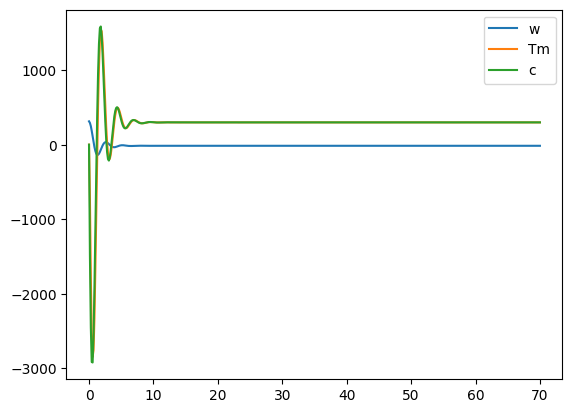

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [2]:
""" --- CONSTANTS --- """

params = {
    # Governor:
    'R': 0.05, # Droop constant
    'Tg': 0.5, # s (governor time constant)
    # Turbine:
    'Tt': 0.1, # s (turbine time constant)
    # Generator:
    'H': 3, # s (inertia constant)
    'D': 1  # s (damping constant) Seconds??
}


""" --- Defining dynamics of the system with states and inputs --- """

def isolatedPowerPlant(t: np.ndarray, x: np.ndarray, u: np.ndarray, params: dict):
    """
    Dynamics of simple isolated Power Plant

    Args:
        t (array): Time
        x (array): States (Frequency, Mechanical Torque, C)
        u (array): Inputs (Electrical Torque, frequency reference)
        params (dict): Dictionary with constants.

    Returns:
        Array of differentials (array): differential update variables
    """
    # Parameter setup
    R = params.get('R')
    Tg = params.get('Tg')
    Tt = params.get('Tt')
    H = params.get('H')
    D = params.get('D')

    # Map the states into local variable names
    w = x[0]
    Tm = x[1]
    c = x[2]

    # Map Inputs
    Te = u[0]
    w_ref = u[1]

    # Compute the discrete updates
    dw = 1/(2*H) * (Tm - D * w - Te)
    dTm = 1/Tt * (-Tm + c)
    dc = 1/Tg * (-c + 1/R * (w_ref - w))

    return np.array([dw, dTm, dc])

""" --- Define Input Output System --- """

io_PowerPlant = control.nlsys(isolatedPowerPlant, None, inputs = ["Te", "w_ref"], states= ["w", "Tm","c"], name = "Isolated Power Plant")

X0 = [2*np.pi*50, 0.8, 1]                 # Initial w, Tm,c
U0 = [2*np.pi*50, 0.8]
T = np.linspace(0, 70, 500)   # Simulation
# Simulate the system
t, y = control.input_output_response(io_PowerPlant, T, U0, X0, params)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.plot(t, y[2])
plt.legend(['w', 'Tm', 'c'])
plt.show(block=False)

lin_io_PowerPlant = io_PowerPlant.linearize(X0,U0)


## Bode plot analysis

Bode plots are used to assess stability by... (fill in some theory)



#### Laplace domain
$$
\Delta \omega = \frac{1}{2Hs} \left( T_m (s) - D \cdot \Delta \omega(s) - T_e (s) \right)
$$

##### Governor
$$
\Delta c = \frac{1}{R} \cdot \frac{1}{T_g s + 1} (\Delta \omega_{\text{ref}} - \Delta \omega)
$$

##### Turbine
$$
T_m = \frac{1}{T_t s + 1} \Delta c
$$

##### Generator
$$
\Delta c = \frac{1}{D} \cdot \frac{1}{(2 H / D) s + 1} (T_m - T_e)
$$



<TransferFunction>: Hg
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


 20
-----
s + 1

<TransferFunction>: Ht
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    1
---------
0.1 s + 1

<TransferFunction>: Hp
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    1
---------
200 s + 1

<TransferFunction>: H_OL
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


               20
--------------------------------
20 s^3 + 220.1 s^2 + 201.1 s + 1

<TransferFunction>: H_CL
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                        400 s^3 + 4402 s^2 + 4022 s + 20
--------------------------------------------------------------------------------
400 s^6 + 8804 s^5 + 5.649e+04 s^4 + 8.936e+04 s^3 + 4.969e+04 s^2 + 8446 s + 41



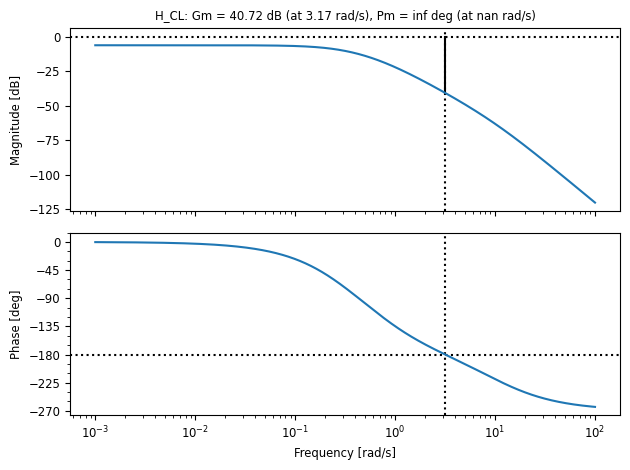

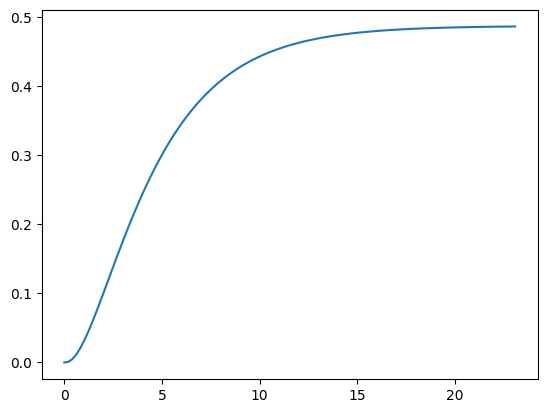

In [ ]:
## Blocks
# Governor:
R = 0.05 # Droop constant
Tg = 1 # s (governor time constant)

Hg = control.TransferFunction((1 / R), [Tg, 1], name='Hg')

print(Hg)

# Turbine:
Tt = 0.1 # s (turbine time constant)
Ht = control.TransferFunction([1], [Tt, 1], name='Ht')

print(Ht)

# Generator:
H = 3 # s (inertia constant)
D = 1 # s (damping constant) Seconds??

Hp = control.TransferFunction([(1 / D)], [2*H/D, 1], name='Hp')

print(Hp)


H_OL = control.TransferFunction(Hg * Ht * Hp, name='H_OL')

print(H_OL)

H_CL = control.feedback(H_OL/(1 + H_OL), name='H_CL')

print(H_CL)

# Bode plot
plt.figure()
# control.bode_plot(H_OL, dB=True, display_margins=False)
control.bode_plot(H_CL, dB=True, display_margins=True)
plt.show()

# Step response
plt.figure()
time, response = control.step_response(H_CL)
plt.plot(time, response)
plt.show()



First we look at the poles;

Poles, eigenvalues, modes, Same thing?

Any poles in the right half plane?

Electromagnetic modes?

When does this work? Linear?

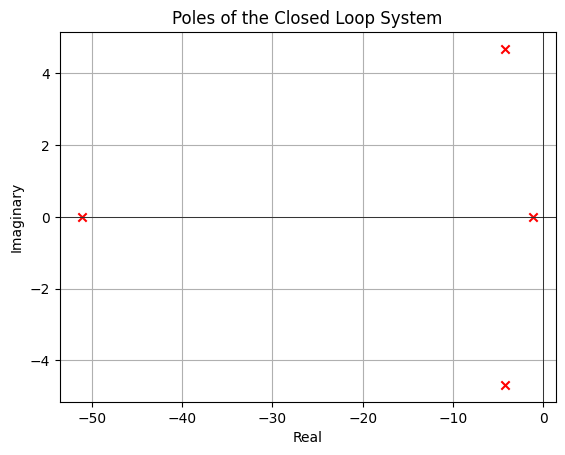

In [34]:
Poles = ClosedLoop.poles()

plt.figure()
plt.scatter(np.real(Poles), np.imag(Poles), marker='x', color='red')
plt.title('Poles of the Closed Loop System')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()
